<a href="https://colab.research.google.com/github/yuvalira/Final-Project-Adversarial-Attack-on-Tabular-Classification/blob/main/GBT/GBT_ModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Standard library
import os
import time
import random

# Data loading
from huggingface_hub import hf_hub_download

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sn

# Scikit-learn: Preprocessing, Modeling, Evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.ensemble import GradientBoostingClassifier

#**Classical Model**
In this section, we implement a classical tree-based machine learning model to serve as a performance baseline for comparison against Large Language Models (LLMs) on a tabular classification task.

Scikit-learn Gradient Boosted Trees (GBT)

This project uses the Gradient Boosted Trees (GBT) implementation from the popular scikit-learn machine learning library.  
GBT is a powerful ensemble learning method that builds models by combining many weak learners (decision trees) into a strong predictive model.  
We selected this approach because it integrates well with tabular data, provides strong performance, and avoids the current compatibility limitations of TensorFlow Decision Forests with Keras 3.

There are other existing implementations of GBT, including TensorFlow Decision Forests [1], XGBoost [2], and LightGBM [3].  
We chose to implement the model using scikit-learn [0] due to its simplicity, stability, and excellent compatibility with research workflows in Python.

References:

[0] Scikit-learn: https://scikit-learn.org/stable/  
[1] TensorFlow Decision Forests: https://www.tensorflow.org/decision_forests  
[2] XGBoost: https://xgboost.readthedocs.io/  
[3] LightGBM: https://lightgbm.readthedocs.io/


### 1. Setup

In [3]:
!pip install -U scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### 2. Data Pre-Processing

Reading data-frames from Huggingface

In [5]:
# Force anonymous download
from huggingface_hub import hf_hub_download
import pandas as pd

repo_id   = "yuvalira/adult_income_balanced"
repo_type = "dataset"

train_path = hf_hub_download(repo_id=repo_id, filename="train.csv",
                             repo_type=repo_type, token=False)
val_path   = hf_hub_download(repo_id=repo_id, filename="val.csv",
                             repo_type=repo_type, token=False)

train_data = pd.read_csv(train_path)
val_data   = pd.read_csv(val_path)

First, we'll track which columns have numerical values and which are categorical. We'll also pay special attention to the target column and weight column.

In [6]:
# Identify numerical columns (int, float)
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify categorical columns (object, category)
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns.tolist()

# Print the feature names (column names)
print("Numerical Features:", numerical_columns)
print("Categorical Features:", categorical_columns)

Numerical Features: ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical Features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']


In [14]:
# Define the columns based on the categories you mentioned
TARGET_COLUMN_NAME = "income"  # The column we're predicting
TARGET_LABELS = [">50K", "<=50K"]  # Enter target labels

# Numeric features based on the output
NUMERIC_FEATURE_NAMES = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week'] # Enter numeric feature

# Categorical features based on the output
CATEGORICAL_FEATURE_NAMES = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country'] # Enter categorical features

Now, we Create copies of dataframes to work on

In [15]:
# Create copies to work on
train_data = train_data.copy()
val_data = val_data.copy()

Now we will show the shapes of the training and test dataframes

In [16]:
print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Train data shape: (11687, 14)
Validation data shape: (2337, 14)


The target column (`income`) is first converted from string labels (`'<=50K'`, `'>50K'`) to numeric values (0, 1) for compatibility with scikit-learn.

In addition, all categorical feature columns are cast to string type to ensure consistency and avoid potential dtype issues during encoding.

This prepares the dataset for subsequent Label Encoding.

In [17]:
def prepare_dataframe(df):
    # Convert the target labels from string to integer.
    df[TARGET_COLUMN_NAME] = df[TARGET_COLUMN_NAME].map(
        TARGET_LABELS.index
    )
    # Cast the categorical features to string.
    for feature_name in CATEGORICAL_FEATURE_NAMES:
        df[feature_name] = df[feature_name].astype(str)


prepare_dataframe(train_data)
prepare_dataframe(val_data)

Before training the Gradient Boosted Trees (GBT) model, it is necessary to convert all categorical (non-numeric) features into numerical format, since scikit-learn models cannot process string data directly.

In this step, we apply Label Encoding to all categorical features. Label Encoding assigns a unique integer value to each category within a feature.

To avoid data leakage, we:

1. fit the encoder only on the training set.

2. apply (transform) the same encoding to the validation and test sets

In [19]:
# Save encoders to reuse
encoders = {}

for col in CATEGORICAL_FEATURE_NAMES:
    # Combine all values for fitting
    combined_values = pd.concat([train_data[col], val_data[col]], axis=0)

    le = LabelEncoder()
    le.fit(combined_values)  # Fit on all available data (to cover all categories)

    # Transform individually to preserve dataset structure
    train_data[col] = le.transform(train_data[col])
    val_data[col] = le.transform(val_data[col])

    encoders[col] = le  # Save for reuse

print("All categorical features encoded successfully.")

All categorical features encoded successfully.


### 3. Model Training & Evaluation
We'll train a **Gradient Boosted Trees (GBT)** model using the `GradientBoostingClassifier` from the scikit-learn library.

This model is chosen because:
- It improves predictive performance over standard decision trees.
- It reduces overfitting by sequentially training trees, each correcting the errors of the previous one.
- It provides flexibility to handle both numerical and encoded categorical features (after preprocessing).
- It integrates seamlessly with the scikit-learn ecosystem and works efficiently for tabular data.

In [20]:
# Gradient Boosted Trees (GBT) model for classification with configured hyperparameters

model_gbt = GradientBoostingClassifier(
    n_estimators=250,       # Number of boosting stages (trees)
    max_depth=5,            # Maximum depth of each tree
    min_samples_leaf=6,     # Minimum number of samples required at a leaf node
    subsample=0.65,         # Fraction of samples to be used for fitting each base learner
    random_state=42         # For reproducibility
)

print("GBT model initialized successfully.")


GBT model initialized successfully.


The run_experiment() method separates features and target labels from the datasets, trains the scikit-learn Gradient Boosting Classifier on the training set, and evaluates its performance on the validation and test sets.

The function calculates standard classification metrics, including accuracy, precision, recall, F1-score, and ROC-AUC.

Training time is also measured to assess computational efficiency.

In [21]:
def run_experiment(model, train_data, val_data):
    # Exclude target
    exclude_columns = [TARGET_COLUMN_NAME]

    # Separate features and labels
    X_train = train_data.drop(columns=exclude_columns)
    y_train = train_data[TARGET_COLUMN_NAME]

    X_val = val_data.drop(columns=exclude_columns)
    y_val = val_data[TARGET_COLUMN_NAME]

    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    training_time = end_time - start_time

    # Evaluate on val set
    y_pred = model.predict(X_val)

    # Correctly Predicted
    correct_predictions = np.sum(y_val == y_pred)
    total_predictions = len(y_val)
    print(f"Correctly Predicted: {correct_predictions}/{total_predictions}")

    # Calculate metrics
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    print(f"Model evaluation complete:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Training Time: {training_time:.4f} seconds")

    return model


In [23]:
model_gbt = run_experiment(model_gbt, train_data, val_data)

Correctly Predicted: 1961/2337
Model evaluation complete:
Accuracy: 0.8391
Precision: 0.8575
Recall: 0.8135
F1 Score: 0.8349
ROC AUC: 0.9233
Training Time: 2.3768 seconds


We extract and display the relative importance of each feature using the trained model's `feature_importances_` attribute.

In [24]:
# Feature importance analysis for sklearn Gradient Boosting
feature_names = train_data.drop(columns=[TARGET_COLUMN_NAME]).columns
importances = model_gbt.feature_importances_

feature_importance_dict = dict(zip(feature_names, importances))
sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print(" Feature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

 Feature Importances:
relationship: 0.2393
marital-status: 0.1541
educational-num: 0.1481
capital-gain: 0.1264
age: 0.1131
hours-per-week: 0.0746
occupation: 0.0438
capital-loss: 0.0400
workclass: 0.0200
education: 0.0190
native-country: 0.0104
race: 0.0068
gender: 0.0046


Receiver Operating Characteristic (ROC) Curve:

ROC curve is a graphical representation of a classifier's performance across different classification thresholds.  
It plots the **True Positive Rate (Sensitivity)** against the **False Positive Rate (1 - Specificity)** at various threshold settings.  
The ROC curve helps to evaluate the trade-off between sensitivity and specificity.  
A model with a curve closer to the top-left corner indicates better performance.  
The **Area Under the Curve (AUC)** summarizes the overall ability of the model to distinguish between the classes, where an AUC of 1.0 represents a perfect classifier and 0.5 represents random guessing.

ROC AUC: 0.9233


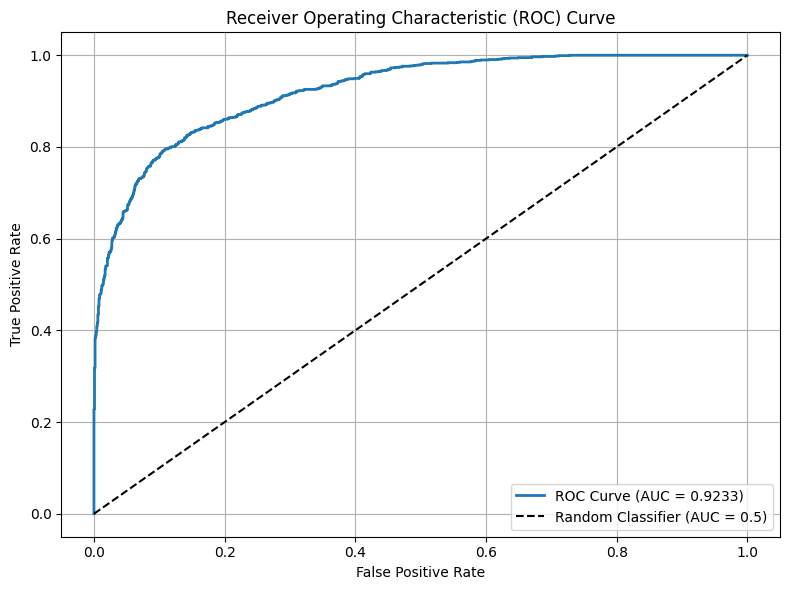

In [25]:
# Prepare test data
X_test = val_data.drop(columns=[TARGET_COLUMN_NAME])
y_true = val_data[TARGET_COLUMN_NAME].values

# Predict probabilities for the positive class
y_proba = model_gbt.predict_proba(X_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## Save the model

In [26]:
import joblib

# Turn repo_id into a safe filename: remove slashes, spaces, etc.
safe_repo_id = repo_id.replace("/", "_").replace(" ", "_")

# Build model filename
model_path = f"model_gbt_{safe_repo_id}.joblib"

# Save in the same folder as the notebook
joblib.dump(model_gbt, model_path)

print(f"Model saved at: {os.path.abspath(model_path)}")

Model saved at: C:\Users\Owner\PycharmProjects\Adversarial-Attacks-Article\models\model_gbt_yuvalira_adult_income_balanced.joblib
